# Week 1 - Function 4 ((15DP, 4D))

# Setup
Let's load all the imports in the top to avoid repeating and simplify the readability of each solution.

In [21]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import norm

from utils.plotting_utils import (
    plot_4D_initial_data,
    plot_output_outliers,
)

# Plan
Recap we have the following data: ((15, 4)) - 15DP & 4D, that can be found `./data/initial_data/function_4/`.

0. Setup:
    1. Load the data
    2. Analyse raw data - visualise data and see patterns
    3. Normalise input & output - this will make it easier to work with the data
    4. Analyse normalise data - verify (visually should look the same)
    5. Output outliers
    6. Early results
1. Build probabilistic Model
2. Acquisition Function


# 0.1. Setup > Load the data

In [22]:
X_train_raw = np.load(r"./data/week_1/function_4/inputs.npy")
y_train_raw = np.load(r"./data/week_1/function_4/outputs.npy")

# 0.2. Setup > Analyse raw data

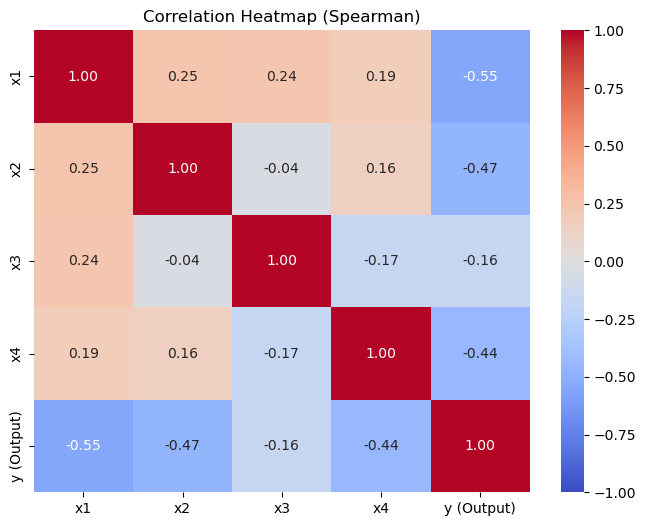

Generating Pairplot...


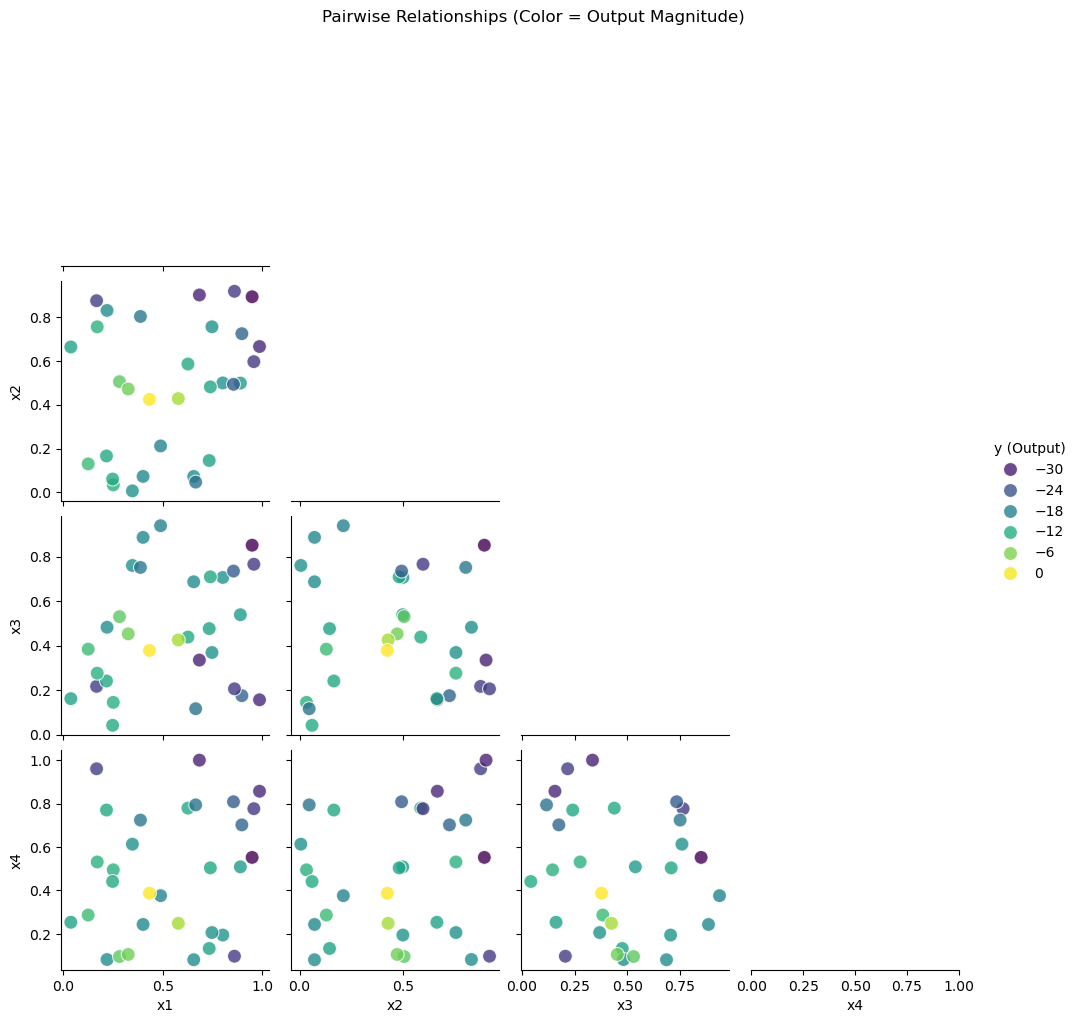

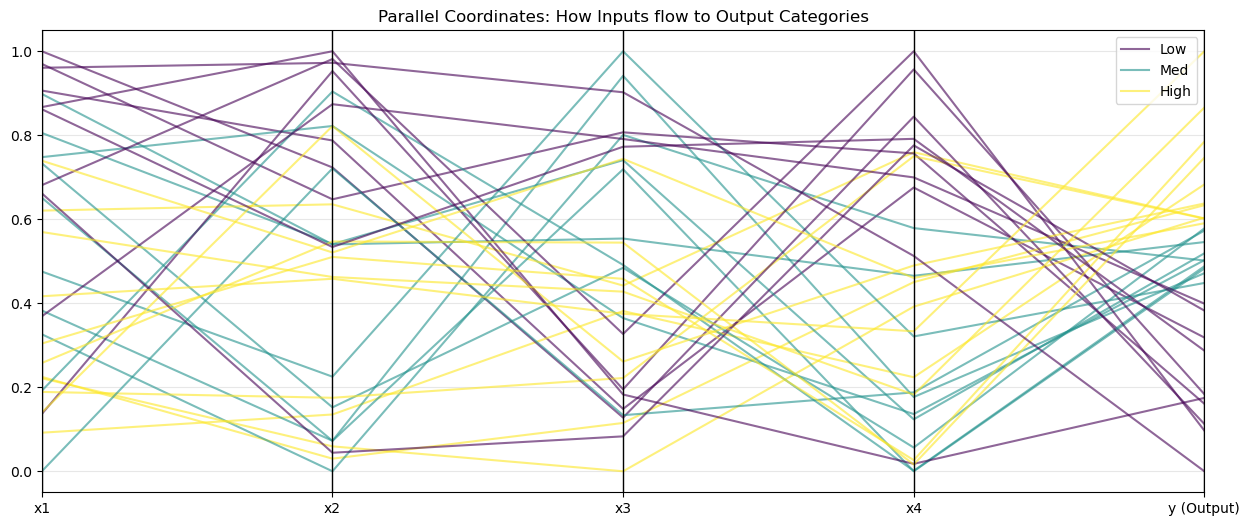

In [23]:
plot_4D_initial_data(X_train_raw, y_train_raw, "Step1: Data points", f"""
DATA SUMMARY
─────────────────────
Points: {len(X_train_raw)}
Input shape: {X_train_raw.shape}
Output shape: {y_train_raw.shape}


CURRENT BEST
─────────────────────
Current best: {np.max(y_train_raw)}
At input: {X_train_raw[np.argmax(y_train_raw)]}
""")

# 0.3. Setup > Normalise the data

In [24]:
# Normalise the data so is easier to visualise + plus needed for BO
# =================================================================
scaler_X = MinMaxScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

# 0.4. Setup > Analyse normalise data

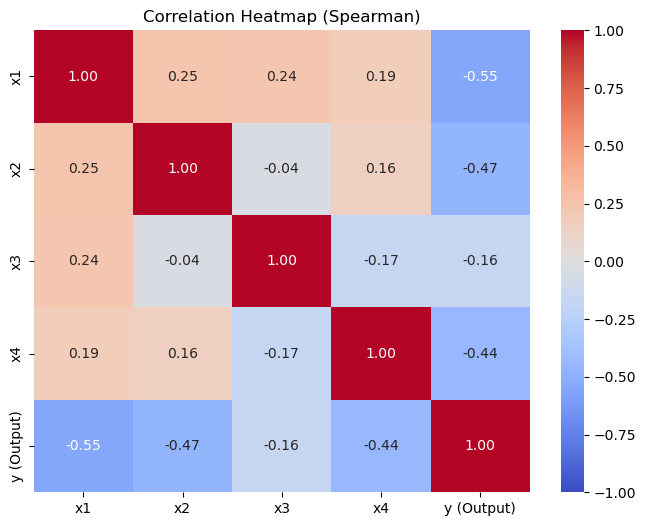

Generating Pairplot...


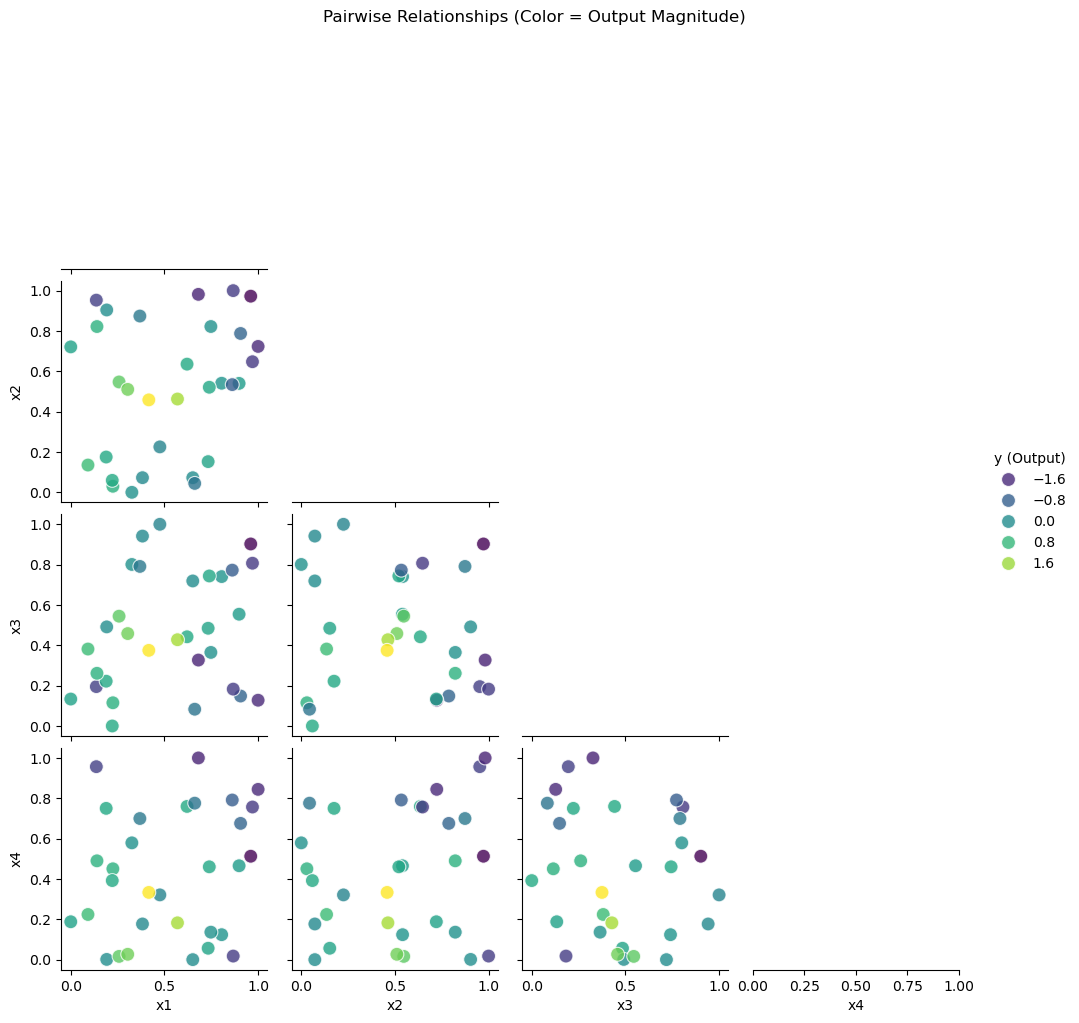

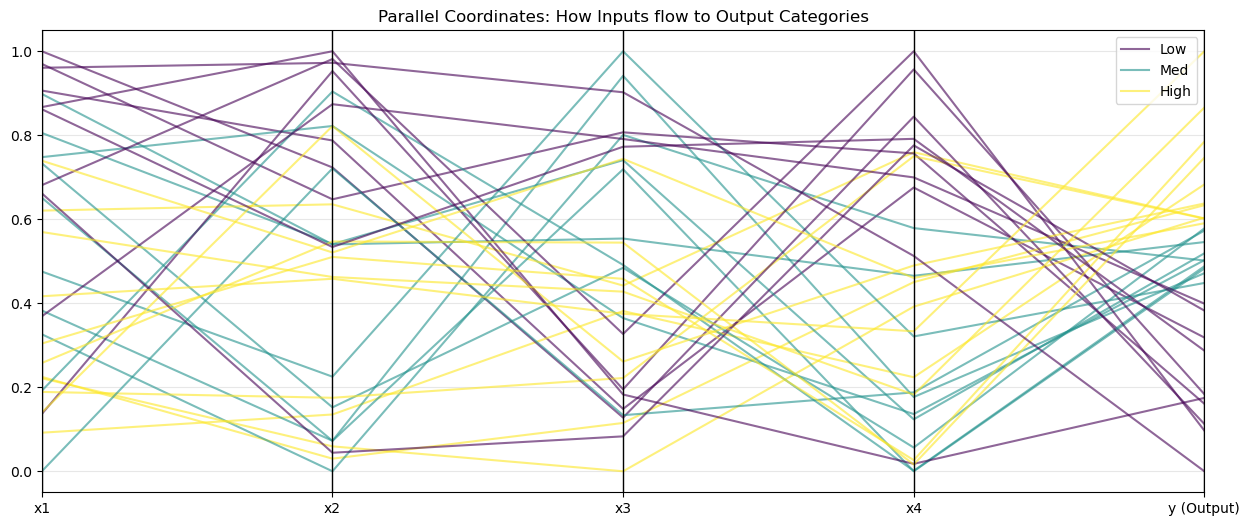

In [25]:
plot_4D_initial_data(X_train, y_train, "Step 4: Normalised", f"""
DATA SUMMARY
─────────────────────
Points: {len(X_train)}
Input shape: {X_train.shape}
Output shape: {y_train.shape}


CURRENT BEST
─────────────────────
Current best: {np.max(y_train)}
At input: {X_train[np.argmax(y_train)]}
""")

# 0.5. Setup > Output outliers

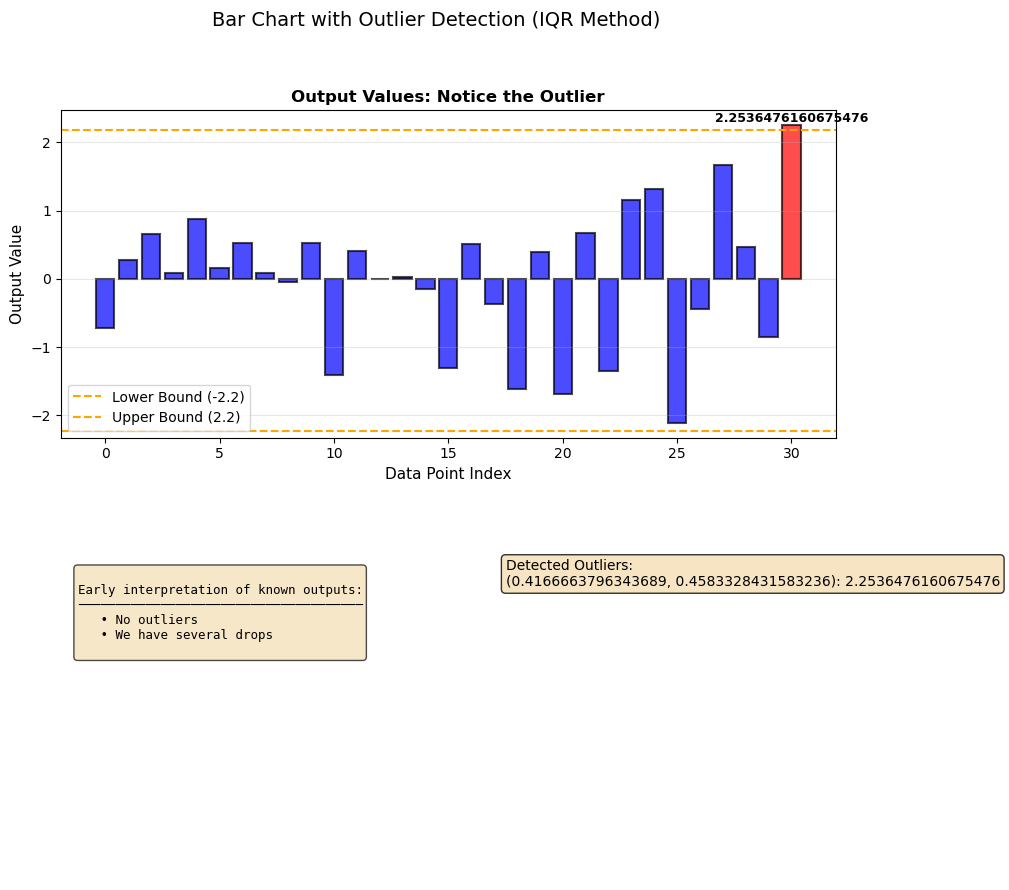

In [26]:
plot_output_outliers(X_train, y_train, "Bar Chart with Outlier Detection (IQR Method)", f"""
Early interpretation of known outputs:
──────────────────────────────────────
   • No outliers
   • We have several drops
""")

# 0.6. Setup > Early data points & outputs analyze

- $x_1$ has strongest correlation with output:
    - Heatmaps shows that clearly: (-0.57).
    - Pairplot shows that where $x_1$ pair is low, it shows the lighter color (higher output).
- $x_2$, $x_4$ moderate correlation:
    - Heatmaps shows that clearly, $x_2$: (-0.47) & $x_2$: (-0.45)
- $x_3$ has little correlation with output:
    - TBC with further inputs and outputs, but potentially we could drop this dimension and get similar results.


# 1. Build probabilistic Model

From early exploration we know that:
- We have several drops
- Sparse data
- $x_3$ looks like noise so it may confuse a model

## Kernel choice
- Matern with ADR so it can adjust the impact of a noisy dimension $x_3$, for now it most likely fail due to little data
- Since there is no big outliers we will have some something in Matern

In [27]:
# Step 1: Kernel + Model
# ======================
kernel = ConstantKernel(1, (1e-5, 1e5)) * Matern(
    length_scale=[1.0, 1.0, 1.0, 1.0], 
    length_scale_bounds=(1e-5, 1e2),
    nu=2.5
) + WhiteKernel(
    noise_level=0.1, 
    noise_level_bounds=(1e-15, 1e1)
)

model = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10
)

model.fit(X_train, y_train)
print(f"Optimized Kernel: {model.kernel_}")

# Check what the model learned about x3
learned_scales = model.kernel_.k1.k2.length_scale
print(f"Learned Length Scales: {learned_scales} (note: failed to recognise the x3)")


#  Create prediction grid
n_grid = 25
x1_range = np.linspace(max(0, X_train[:, 0].min() - 0.5), min(0.999999, X_train[:, 0].max() + 0.5), n_grid)
x2_range = np.linspace(max(0, X_train[:, 1].min() - 0.5), min(0.999999, X_train[:, 1].max() + 0.5), n_grid)
x3_range = np.linspace(max(0, X_train[:, 2].min() - 0.5), min(0.999999, X_train[:, 2].max() + 0.5), n_grid)
x4_range = np.linspace(max(0, X_train[:, 3].min() - 0.5), min(0.999999, X_train[:, 3].max() + 0.5), n_grid)

X1_test, X2_test, X3_test, X4_test = np.meshgrid(x1_range, x2_range, x3_range, x4_range)
X_grid = np.c_[X1_test.ravel(), X2_test.ravel(), X3_test.ravel(), X4_test.ravel()]

# Make predictions
mu, sigma = model.predict(X_grid, return_std=True)


Optimized Kernel: 2.9**2 * Matern(length_scale=[1.53, 1.48, 1.66, 1.45], nu=2.5) + WhiteKernel(noise_level=1.16e-15)
Learned Length Scales: [1.5346636  1.48396287 1.65668263 1.44766656] (note: failed to recognise the x3)


# 2. Acquisition function

Since we found a high spike the model thinks we are in a global maximum, but we are early on the discovery of the training, so let's shift to UCB to force the model to explore.

In [28]:
def expected_improvement(mu, sigma, y_best, xi=0.1):
    """
    Expected Improvement acquisition function

    EI = E[max(f(x) - f(x_best), 0)]
    
    Parameters:
        mu: Mean predictions from GP
        sigma: Standard deviation from GP
        y_best: Current best observed value (in normalized space)
        xi: Exploration parameter (higher = more exploration)
        
    Returns:
        ei: Expected improvement values
    """
    with np.errstate(divide='warn'):
        improvement = mu - y_best - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

def upper_confidence_bound(mu, sigma, kappa=2.0):
    """
    Upper Confidence Bound (UCB) acquisition function.
    
    UCB = mean + kappa * std
    
    Parameters:
    -----------
    mu : predicted mean
    sigma : predicted standard deviation
    kappa : exploration parameter (higher = more exploration)
    """
    return mu + kappa * sigma


ucb_values = upper_confidence_bound(mu, sigma, kappa=10.0)
print(f"\nExpected Improvement (UCB):")
print(f"  Min: {ucb_values.min():.8f}")
print(f"  Max: {ucb_values.max():.8f}")
print(f"  Mean: {ucb_values.mean():.8f}")

print("\nSTEP 7: Finding best next point to evaluate...")

best_idx = np.argmax(ucb_values)
x_next_norm = X_grid[best_idx]
ei_best = ucb_values[best_idx]

# Convert to original space
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

print(f"\n{'='*80}")
print(f"RECOMMENDED NEXT POINT")
print(f"{'='*80}")
print(f"\nIn original space:")
print(f"  Input 1: {x_next_orig[0]:.6f}")
print(f"  Input 2: {x_next_orig[1]:.6f}")
print(f"  Input 3: {x_next_orig[2]:.6f}")
print(f"  Input 4: {x_next_orig[3]:.6f}")
print(f"\nIn normalized space:")
print(f"  Input 1: {x_next_norm[0]:.6f}")
print(f"  Input 2: {x_next_norm[1]:.6f}")
print(f"  Input 3: {x_next_norm[2]:.6f}")
print(f"  Input 4: {x_next_norm[3]:.6f}")

# Get prediction at this point
y_pred_next, y_std_next = model.predict([x_next_norm], return_std=True)
y_pred_next_orig = scaler_y.inverse_transform([[y_pred_next[0]]])[0, 0]

print(f"\nPredicted output at this point:")
print(f"  Normalized: {y_pred_next[0]:.6f} ± {y_std_next[0]:.6f}")
print(f"  Original: {y_pred_next_orig:.6f}")
print(f"  95% CI: [{y_pred_next_orig - 1.96*y_std_next[0]:.6f}, {y_pred_next_orig + 1.96*y_std_next[0]:.6f}]")

print(f"\nExpected Improvement at this point: {ei_best:.8f}")

print(f"UCB Range: {ucb_values.min():.4f} to {ucb_values.max():.4f}")

# y_best_norm = np.max(y_train)

# xi = 0.02 # a bit more agressive in this phase to increase exploration

# ei_values = expected_improvement(mu, sigma, y_best_norm, xi=xi)

# print(f"\nExpected Improvement (EI):")
# print(f"  Min: {ei_values.min():.8f}")
# print(f"  Max: {ei_values.max():.8f}")
# print(f"  Mean: {ei_values.mean():.8f}")

# print("\nSTEP 7: Finding best next point to evaluate...")

# best_idx = np.argmax(ei_values)
# x_next_norm = X_grid[best_idx]
# ei_best = ei_values[best_idx]

# # Convert to original space
# x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

# print(f"\n{'='*80}")
# print(f"RECOMMENDED NEXT POINT")
# print(f"{'='*80}")
# print(f"\nIn original space:")
# print(f"  Input 1: {x_next_orig[0]:.6f}")
# print(f"  Input 2: {x_next_orig[1]:.6f}")
# print(f"  Input 3: {x_next_orig[2]:.6f}")
# print(f"  Input 4: {x_next_orig[3]:.6f}")
# print(f"\nIn normalized space:")
# print(f"  Input 1: {x_next_norm[0]:.6f}")
# print(f"  Input 2: {x_next_norm[1]:.6f}")
# print(f"  Input 3: {x_next_norm[2]:.6f}")
# print(f"  Input 4: {x_next_norm[3]:.6f}")

# # Get prediction at this point
# y_pred_next, y_std_next = model.predict([x_next_norm], return_std=True)
# y_pred_next_orig = scaler_y.inverse_transform([[y_pred_next[0]]])[0, 0]

# print(f"\nPredicted output at this point:")
# print(f"  Normalized: {y_pred_next[0]:.6f} ± {y_std_next[0]:.6f}")
# print(f"  Original: {y_pred_next_orig:.6f}")
# print(f"  95% CI: [{y_pred_next_orig - 1.96*y_std_next[0]:.6f}, {y_pred_next_orig + 1.96*y_std_next[0]:.6f}]")

# print(f"\nExpected Improvement at this point: {ei_best:.8f}")


Expected Improvement (UCB):
  Min: -1.93759867
  Max: 6.94372601
  Mean: 2.16420511

STEP 7: Finding best next point to evaluate...

RECOMMENDED NEXT POINT

In original space:
  Input 1: 0.037825
  Input 2: 0.006250
  Input 3: 0.939177
  Input 4: 0.999482

In normalized space:
  Input 1: 0.000000
  Input 2: 0.000000
  Input 3: 0.999999
  Input 4: 0.999999

Predicted output at this point:
  Normalized: -1.293692 ± 0.823742
  Original: -26.468975
  95% CI: [-28.083509, -24.854441]

Expected Improvement at this point: 6.94372601
UCB Range: -1.9376 to 6.9437
